# Model tests
VMM:s will be developed for the reference ship using motion regression based on a series of model tests with a model that is free in six degrees of freedome. A summary of the available model tests is shown in {ref}`tab:df_runs_table`.

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import pandas as pd
pd.set_option('display.max_columns', 500)
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmms = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)S

2022-02-01 16:31:09,196 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-02-01 16:31:10,075 - root - INFO - ** Kedro project wPCC_pipeline
2022-02-01 16:31:10,075 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-01 16:31:10,086 - root - INFO - Registered line magic `run_viz`


E:\dev\wPCC_pipeline\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
E:\dev\wPCC_pipeline\venv\lib\site-packages\mlflow\types\schema.py:49: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary = (7, np.dtype("bytes"), "BinaryType", np.object)


In [2]:
ship_data = catalog.load("ship_data")

#from wPCC_pipeline.pipelines.preprocess.nodes import track_plot
from src.visualization.plot import track_plots, track_plot, plot

2022-02-01 16:31:13,414 - kedro.io.data_catalog - INFO - Loading data from `ship_data` (YAMLDataSet)...


In [9]:
dataframes = {}
df = pd.DataFrame()

for id in model_test_ids:
    
    df_ = catalog.load(f"{ id }.raw_data")
    df_['psi+'] = df_['psi'] + np.deg2rad(90)
    df_['-y0'] = -df_['y0']
    df_['delta_deg'] = np.rad2deg(df_['delta'])
    
    dataframes[id] = df_


2022-02-01 16:32:21,149 - kedro.io.data_catalog - INFO - Loading data from `22611.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,177 - kedro.io.data_catalog - INFO - Loading data from `22612.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,229 - kedro.io.data_catalog - INFO - Loading data from `22613.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,275 - kedro.io.data_catalog - INFO - Loading data from `22614.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,324 - kedro.io.data_catalog - INFO - Loading data from `22615.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,372 - kedro.io.data_catalog - INFO - Loading data from `22616.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,418 - kedro.io.data_catalog - INFO - Loading data from `22635.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,478 - kedro.io.data_catalog - INFO - Loading data from `22639.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,541 - kedro.io.data_catalog - INFO - Loading data from `22764.raw_data` (CSVDataSet)...
2022-02-01 16:32:21,590 - ke

In [10]:
df_runs = catalog.load("runs_meta_data")
df_runs.index = df_runs.index.astype('str')
df_runs = df_runs.loc[model_test_ids].copy()

mask = df_runs['test_type'] == 'rodergrundvinkel'
df_runs.loc[mask,'test_type'] = 'yaw rate'
mask = df_runs['test_type'] != 'zigzag'
df_runs.loc[mask,'comment'] = np.NaN
mask = ((df_runs['comment'].notnull()) & (df_runs['test_type'] == 'zigzag'))
df_runs['angle'] = df_runs.loc[mask,'comment'].apply(lambda x:int(x[3:5]))
df_runs['direction'] = df_runs.loc[mask,'comment'].apply(lambda x:x[8:11])

df_runs.sort_values(by=['test_type','ship_speed','angle'], inplace=True)

df_runs_table = df_runs.rename(columns={'ship_speed':'Initial speed [m/s]','test_type':'type'})
df_runs_table = df_runs_table[['Initial speed [m/s]','type','angle','direction']]

formatter={'Initial speed [m/s]' : "{:.2f}", 'angle' : "{:.0f}"}

df_runs_table = df_runs_table.style.format(formatter=formatter, na_rep='')

glue("df_runs_table", df_runs_table)

2022-02-01 16:32:22,577 - kedro.io.data_catalog - INFO - Loading data from `runs_meta_data` (CSVDataSet)...


,Initial speed [m/s],type,angle,direction
id,,,,
22639,0.64,reference speed,,
22635,0.80,reference speed,,
22611,0.96,reference speed,,
22774,0.96,turning circle,,
22612,0.96,yaw rate,,
22613,0.96,yaw rate,,
22614,0.96,yaw rate,,
22615,0.96,yaw rate,,
22616,0.96,yaw rate,,


```{glue:figure} df_runs_table
:name: "tab:df_runs_table"

Model tests
```

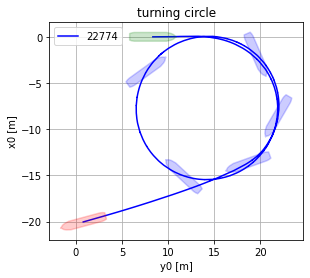

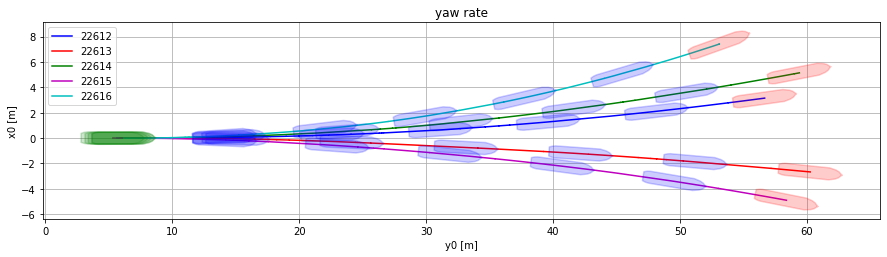

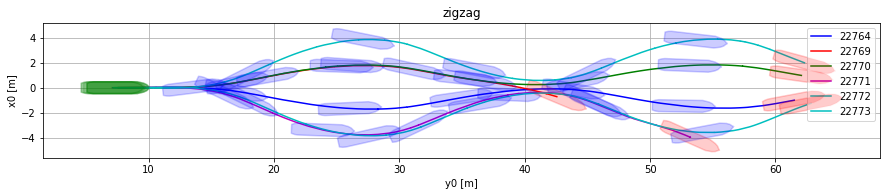

In [16]:
for test_type, df_ in df_runs.groupby(by=['test_type']):
    
    dataframes_ = {key:value for key,value in dataframes.items() if key in df_.index}
    
    if test_type == 'reference speed':
        continue
    
    fig = track_plots(dataframes=dataframes_, lpp=ship_data['L'], beam=ship_data['B'], x_dataset='-y0',
    y_dataset='x0', psi_dataset='psi+', plot_boats=True, N=7)
    ax = fig.axes
    ax.set_title(f"{test_type}")

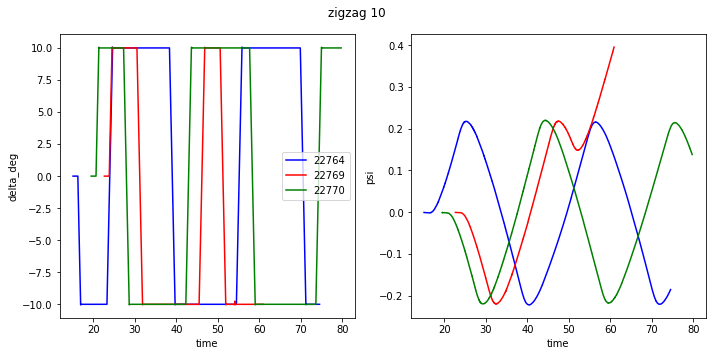

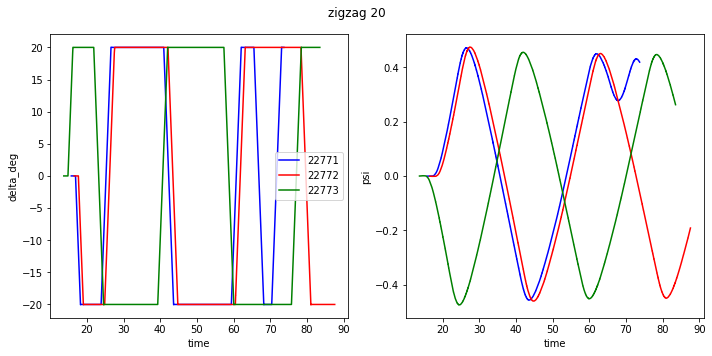

In [12]:
for (test_type,angle), df_ in df_runs.groupby(by=['test_type','angle']):
    
    dataframes_ = {key:value for key,value in dataframes.items() if key in df_.index}
    
    if test_type == 'reference speed':
        continue
    
    fig = plot(dataframes=dataframes_, keys=['delta_deg','psi'], fig_size=(10, 5))
    fig.suptitle(f"{test_type} {int(angle)}")
    plt.tight_layout()